## Single-wire example for magnetostatic FEM

To do: Take a closer look how a non-constant $\mu$ impacts the calculations. It seems obvious that both the analytical solution and finite element solution are no longer valid as they have been derived here (particularly the curl-curl identity I have used is definitely no longer applicable in that case).

### Analytical solution
We examine the Maxwell equation
$$ \nabla \times B = \frac{\partial E}{\partial t} + \mu_0 j $$
which simplifies in static configurations, where $\partial E / \partial t = 0$. Integrating on a disk of radius $R$ orthogonal to the wire of radius $r$, satisfying $R > r$, we have
$$ \int_{D(R)} \nabla \times B \cdot d\sigma = \mu_0 \int_{D(R)} j \cdot ~d\sigma $$
Applying Stokes' theorem, and using the definition of current, we obtain
$$ \int_{\partial D(R)} B \cdot ds = \mu_0 J $$
Since $B$ will always be parallel to $ds$, we can restrict our calculations to the magnitude of $B$ at distance $R$ from the wire, which due to spherical symmetry, will be constant for all points in $\partial D(R)$, hence we deduce
$$ 2 \pi R B(R) = \mu_0 J ~\implies~ B(R) = \frac{\mu_0 J}{2 \pi R}, ~\text{if}~ R > r $$
In the case $R < r$, and supposing the current is uniformly distributed in the wire, we need to only account for the ratio of current $J(R)$ in the wire, which flows through the integration disk $D(R)$. With $J(R) = (R/r)^2$, we get
$$ B(R) = \frac{\mu_0 R}{2 \pi r^2}, ~\text{if}~ R < r  $$

### Finite element solution
Proceeding from the same Maxwell equation as for the analytical solution, and writing $B = \nabla \times A$ for some vector potential $A$ (utilizing the non-existence of magnetic monopoles), we obtain
$$ \nabla \times \nabla \times A = \mu_0 j $$
We may convert this equation using basic vector calculus identities:
$$ \nabla \cdot (\nabla \cdot A) - \Delta A = \mu_0 j $$
In a Coulomb gauge, we set $\nabla \cdot A = 0$, without losing generality, and reduce our examination to the $z$-component of the vector potential $A_z$ (since all other components are essentially zero if we assume the wire to extend to $\pm \infty$). Consequently end up with a Poisson-type differential equation, which we can convert to its weak formulation 
$$ - \Delta A_z = \mu_0 j_z ~\implies~ \int_{D(R)} \mu_0^{-1} \nabla A_z \cdot \nabla v ~d\sigma  = \int_{D(R)} j_z v ~d\sigma $$

### FEniCS Implementation of finite element solution
Implementation closely follows Chapter 4.5 in Langtangen, Logg: Solving PDEs in Python - The FEniCS Tutorial I.

Remark: Setting the boundary condition

$$ A_z(x, y) = 0, ~\forall (x, y) \in \partial D(R) $$

is only justyfiable for this exact system, where we have a radial symmetry. This allows us to deduce that $A_z$ must be constant on the edge of the disk $\partial D(R)$, and because we can add any constant to $A_z$ without altering the physical outcome of the calculation (since we are only interested in derivatives of the potential), we can set it to zero on $\partial D(R)$.

In [1]:
from fenics import *
from mshr import *
%matplotlib inline

In [2]:
r = 0.5 # radius of wire
R = 5.0 # radius of domain

# Set the domain
domain = Circle(Point(0, 0), R)

# Set a subdomain (the wire)
wire = Circle(Point(0, 0), r)
domain.set_subdomain(1, wire)

In [3]:
# Generating the mesh
mesh = generate_mesh(domain, 32)

# Define function space
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition. Here, we use both the radial
# symmetry of the system at hand, as well as a gauge
# condition A(R) = 0. 
bc = DirichletBC(V, Constant(0), 'on_boundary')

# Define subdomain markers and integration measure
markers = MeshFunction('size_t', mesh, 2, mesh.domains())
dx = Measure('dx', domain=mesh, subdomain_data=markers)

# Define current density (1 A)
J = Constant(1.0)

# Visuazlizing the mesh
mesh

In [4]:
class Permeability(UserExpression):
    def __init__(self, markers, **kwargs):
        super().__init__(**kwargs)
        self.markers = markers
    def eval_cell(self, values, x, cell):
        if self.markers[cell.index] == 0:
            values[0] = 4*pi*1e-7 # vacuum
        else:
            values[0] = 1.26e-6   # copper
            
mu = Permeability(markers, degree=1)

### Vector potential (finite element solution)

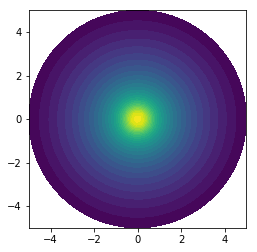

In [5]:
# Define variational problem
A_z = TrialFunction(V)
v = TestFunction(V)
a = (1 / mu)*dot(grad(A_z), grad(v))*dx
L = J*v*dx(1)

# Solve variational problem
A_z = Function(V)
solve(a == L, A_z, bc)

plot(A_z)

### Magnetic field strength (finite element solution)

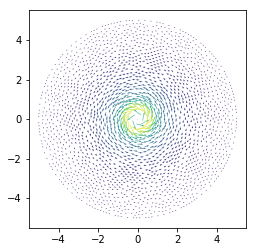

In [6]:
# Compute magnetic field (B = curl A)
W = VectorFunctionSpace(mesh, 'P', 1)
B = project(as_vector((A_z.dx(1), -A_z.dx(0))), W)

plot(B)

### Magnetic field strength (analytical solution)

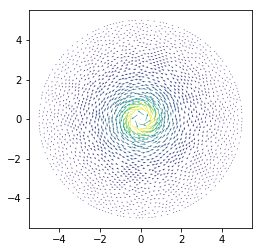

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize

def B_analytical(x):
    # Magnetic field strength inside the wire (see derivation above)
    if pow(x[0]*x[0] + x[1]*x[1], 0.5) < r:
        B_x0 = - 4*pi*1e-7 * pow(x[0]*x[0] + x[1]*x[1], 0.5) / (2 * 3.141596 * r * r) * sin(np.arctan2(x[1], x[0]))
        B_x1 = 4*pi*1e-7 * pow(x[0]*x[0] + x[1]*x[1], 0.5) / (2 * 3.141596 * r * r) * cos(np.arctan2(x[1], x[0]))
    # Magnetic field strength outside the wire (see derivation above)
    else:
        B_x0 = - 4*pi*1e-7 * 1 / (2 * 3.141596 * pow(x[0]*x[0] + x[1]*x[1], 0.5)) * sin(np.arctan2(x[1], x[0]))
        B_x1 = 4*pi*1e-7 * 1 / (2 * 3.141596 * pow(x[0]*x[0] + x[1]*x[1], 0.5)) * cos(np.arctan2(x[1], x[0]))
    return [B_x0, B_x1]

# Set figure to visualize analytical solution
plt.figure(figsize=(4, 4))
vertices = mesh.coordinates()
B_exact = np.array(list(map(B_analytical, vertices)))

# Color the quivers according to their length (to mimick above plot)
# https://stackoverflow.com/questions/40026718/different-colours-for-arrows-in-quiver-plot
colors = np.linalg.norm(B_exact, axis=1)
norm = Normalize()
norm.autoscale(colors)
colormap = cm.viridis

# Quiver plot the vector field
plt.quiver(vertices[:, 0], vertices[:, 1], B_exact[:, 0], B_exact[:, 1], color=colormap(norm(colors)))